# CStore Performance Vs. Row Store


At Data Lab, we ran performance tests of various scenarios against many open-source DBMSs.  The cstore_fdw (for columnar store, foreign data wrapper), proved very fast.  Below we compare the run time between both storage formats.  (For more on cstore see https://github.com/citusdata/cstore_fdw)

Basic Imports

In [17]:
# std lib
from cStringIO import StringIO
import getpass

# 3rd party
import numpy as N
import pylab as p
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import FileLink

# Datalab
from dl import authClient as ac, queryClient as qc, helpers


In [4]:
# anonymous login (some functionality is limited)
token = ac.login('anonymous') # username, here anonymous

# Query against Rowstore

In [8]:
%%time
query = """SELECT min(flux_g), max(flux_g), avg(flux_g),
                  min(flux_r), max(flux_r), avg(flux_r),
                  min(flux_z), max(flux_z), avg(flux_z)
           FROM ls_dr5.tractor
           WHERE psfsize_r > 0.6635 and psfsize_r < 1.327"""

# Send the query to the Queryclient in SQL, with a comma-separated-value (csv) output
response = qc.query(token, sql=query, fmt='csv')

CPU times: user 27 ms, sys: 10 ms, total: 37 ms
Wall time: 9min 31s


In this run, it took **9min 31s** to execute the query against the normal rowstore table in Postgres.  Since `psfsize_r` is not indexed (only bold columns listed here are indexed: http://datalab.noao.edu/query.php?name=ls_dr3.tractor), the database has to read through every row in `ls_dr5.tractor` to find all rows satisfying the WHERE clause.

Compare this to the next run.
# Query Against CStore

In [9]:
%%time
query = """SELECT min(flux_g), max(flux_g), avg(flux_g),
                  min(flux_r), max(flux_r), avg(flux_r),
                  min(flux_z), max(flux_z), avg(flux_z)
           FROM ls_dr5.tractor_cs
           WHERE psfsize_r > 0.6635 and psfsize_r < 1.327"""

# Send the query to the Queryclient in SQL, with a comma-separated-value (csv) output
response = qc.query(token, sql=query, fmt='csv')

CPU times: user 21 ms, sys: 5 ms, total: 26 ms
Wall time: 4min 21s


This time, we queried against a cstore table (denoted by the `_cs` in the table name in the query above), and it took less than half the time at **4min 21s**.  Since cstore tables store the min/max values of each stripe, they have an inherent index **on every column** that requires litte extra space to store on disk.

# Graph of results

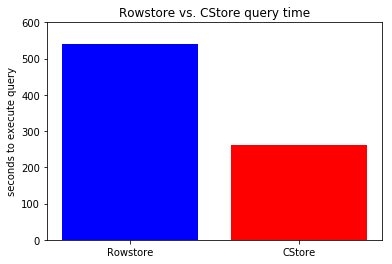

In [24]:
x = [1,2]
y = [540,261]
ax = plt.subplot()
pr, pc = plt.bar(x,y)
pr.set_facecolor('b')
pc.set_facecolor('r')
ax.set_xticks(x)
ax.set_xticklabels(['Rowstore','CStore'])
ax.set_ylim([0,600])
ax.set_ylabel('seconds to execute query')
ax.set_title('Rowstore vs. CStore query time')

# When should I use CStore tables in Data Lab?
We recommend running your query against a cstore table when your query's WHERE clause is against unindexed columns.

~~~~
SELECT <...>
FROM <...>_cs
WHERE unindexed_column <...>
~~~~

If some columns in the WHERE clause are indexed and others are not, there is not a universal recommendation.  A useful rule-of-thumb is when the number of rows to sample is > ~100,000 *after* applying the conditions of the indexed columns, you might try a cstore table to see if performance improves.
